**Criado por Lucas Zanferrari Caraça em maio de 2017**  <br/>
[https://github.com/lucas-zanferrari][1] <br/>
[https://www.linkedin.com/in/lucas-zanferrari](https://www.linkedin.com/in/lucas-zanferrari) <br/>


  [1]: https://github.com/lucas-zanferrari

Os objetivos deste notebook são:
- treinar um modelo de análise de sentimentos, baseado em uma base de dados de avaliações de corridas do Uber, utilizando a implementação do algoritmo de Naive Bayes da biblioteca NLTK.
- em conjunto com os outros 2 notebooks deste estudo, comparar a acurácia do analisador de sentimentos aqui treinado com a acurácia dos outros.
- concluir empiricamente que a base SAR14 produz modelos mais precisos que o modelo aqui treinado. 

A base de dados usada chama-se Uber Ride Reviews Dataset. Ela consiste em avaliações de corridas do Uber e foi introduzida compilada por Purvank (https://www.kaggle.com/purvank) através do web scrapping das páginas https://www.consumeraffairs.com/travel/uber.html e https://www.sitejabber.com/reviews/www.uber.com#reviews.


Primeiramente, é preciso importar a bibliotecas necessárias para as computações que serão realizadas neste estudo. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

Após isso, o arquivo com o corpus é lido em um DataFrame do Pandas.

In [2]:
data = pd.read_csv('data/Uber_Ride_Reviews.csv')
data.head(10)

,ride_review,ride_rating,sentiment
0,I completed running New York Marathon requeste...,1.0,0
1,My appointment time auto repairs required earl...,1.0,0
2,Whether I using Uber ride service Uber Eats or...,1.0,0
3,Why hard understand I trying retrieve Uber cab...,1.0,0
4,I South Beach FL I staying major hotel ordered...,1.0,0
5,I damage vehicle due Uber driver upstairs neig...,1.0,0
6,I use Uber fairly frequently Overall good serv...,2.0,0
7,Last night I returned home airport using Uber ...,1.0,0
8,Do lose anything Uber otherwise experience nig...,1.0,0
9,My last experiences Uber made use taxis turned...,1.0,0


A seguir, a base de dados é dividida em base de treinamento e base de teste. É uma prática comum que 20% do total da base seja destinado a testes e 80%, a treinamento. 

In [3]:
train, test = train_test_split(data, test_size=0.2)

Para este estudo, as análises das viagens de Uber presentes no corpus foram dividas em positivas (notas maiores ou iguais a 3) e negativas (notas menores que 3) apenas, mas é possível treinar o classificador para classificar em quantas classes forem desejadas.

Chamaremos 3 de limiar positivo. O limiar positivo foi definido empiricamente ao treinar o modelo repetidas vezes e observar sua acurácia em cada caso para limiares positivos de 2 a 4. O limiar positivo igual a 3 foi o que, na média, apresentou melhor acurácia, tanto para classficar entradas como positivas quanto negativas.

In [4]:
pos_threshold = 3
train_pos = train[train['ride_rating'] >= pos_threshold]
train_neg = train[train['ride_rating'] < pos_threshold]

Depois de dividir a base de treinamento nas duas classes desejadas, duas representações em forma de nuvem de palavras são exibidas para facilitar a identificação de palavras majoritariamente associadas a avaliações positivas e negativas.

In [5]:
def print_wordcloud(data, bg_color):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                  background_color=bg_color,
                  width=3000,
                  height=2000
                ).generate(words)
    plt.figure(1, figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Palavras associadas a avaliações positivas


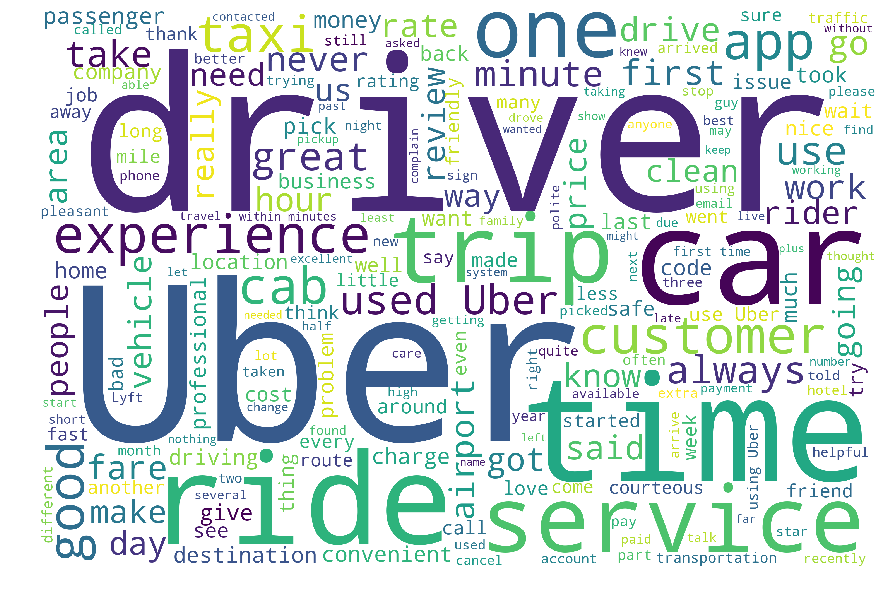

In [6]:
print("Palavras associadas a avaliações positivas")
print_wordcloud(train_pos['ride_review'], 'white')

Palavras associadas a avaliações negativas


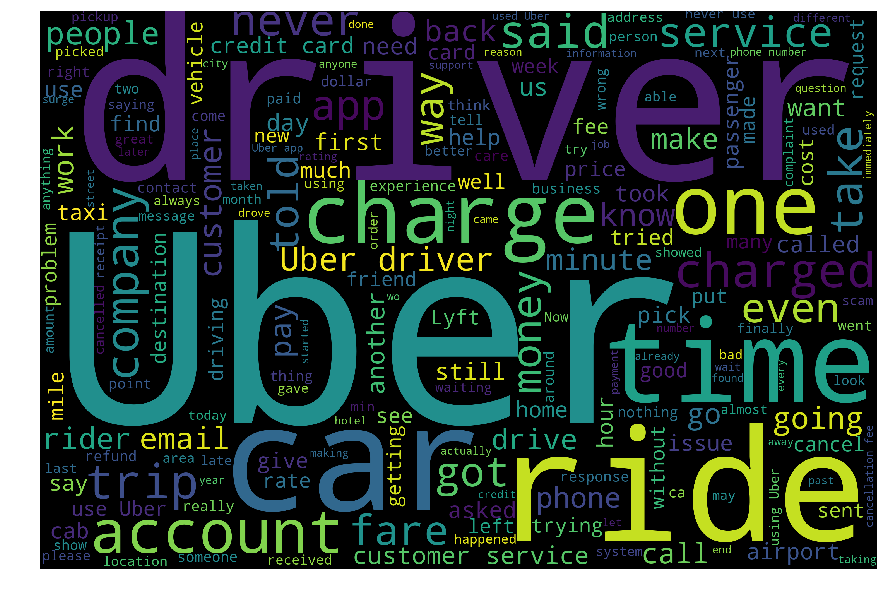

In [7]:
print("Palavras associadas a avaliações negativas")
print_wordcloud(train_neg['ride_review'], 'black')

Adiante, uma heurística para a conversão de notas em sentimentos é definida. Como mencionado previamente, a regra adotada por este estudo foi atribuir a classe "positive" para as avaliações com nota maior ou igual a 3, e "negative" para as demais.

As stopwords também são removidas em sua totalidade da base de treinamento. 

Stopwords são palavras inúteis para a avaliação a ser executada. Normalmente são palavras curtas (dois caraceteres ou menos), muito frequentes e que representam pouca ou nenhuma informação ("or", "of", "in", "at" etc). O NLTK contém uma lista de stopwords comuns em textos da língua inglesa, e esta lista foi utilizada neste estudo.

In [8]:
def convert_grade_to_sentiment(rating, pos_threshold):
    return "positive" if rating >= pos_threshold else "negative"

In [9]:
train_reviews = []
stopwords_set = set(nltk.corpus.stopwords.words('english'))

for index, row in train.iterrows():
    words_filtered = [rvw.lower() for rvw in row['ride_review'].split(" ") if len(rvw) >= 3]
    words_without_stopwords = [word for word in words_filtered if not word in stopwords_set]
    train_reviews.append((words_without_stopwords, convert_grade_to_sentiment(row['ride_rating'], pos_threshold)))

Depois, a base de dados de testes é separada.

In [10]:
test_pos = test[test['ride_rating'] >= pos_threshold]
test_neg = test[test['ride_rating'] < pos_threshold]

A seguir, funções para a extração de todas as palavras de um review em forma de lista, da "bag-of-words" e dos atributos textuais do corpus no formato esperado pelo NLTK são definidas.

In [11]:
def get_all_words(reviews):
    all_words = []
    for (words, grade) in reviews:
        all_words.extend(words)
    return all_words

def get_bag_of_words(all_words):
    return nltk.FreqDist(all_words)

all_words = get_all_words(train_reviews)
bag_of_words = get_bag_of_words(all_words)
word_features = bag_of_words.keys()

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

As palavras mais frequentes em todo o corpus são impressas em forma de nuvem de palavras. É possível observar que a maioria possui um tom neutro ao se referir ao universo de produções cinematrográficas, ou seja, podem ser utilizadas tanto em contexto positivos quanto negativos.

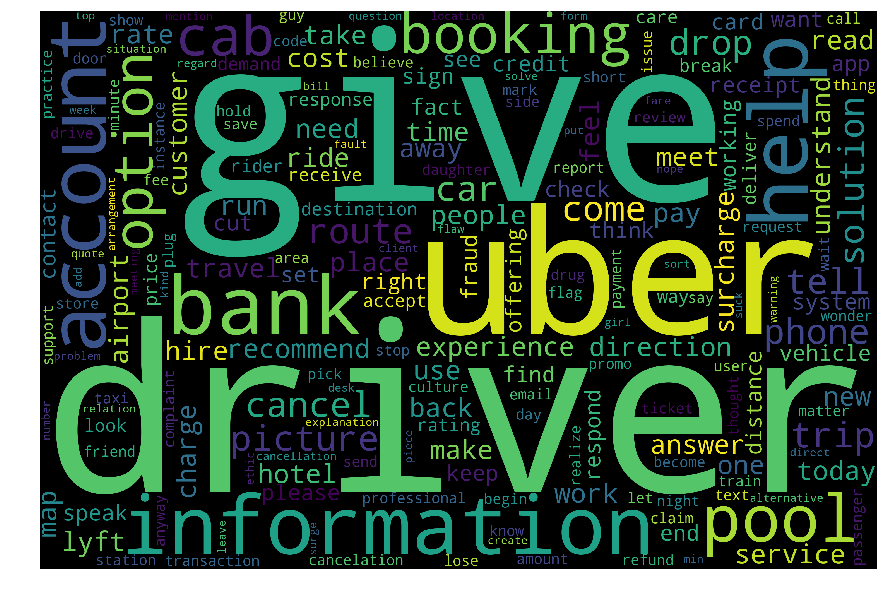

In [12]:
print_wordcloud(bag_of_words, 'black')

O classificador de Naive Bayes foi treinado utilizando os atributos textuais da base de treinamento sem as stopwords.

In [13]:
training_set = nltk.classify.apply_features(extract_features, train_reviews)
classifier = nltk.NaiveBayesClassifier.train(training_set)

Por fim, a contagem de classificações positivas e negativas é efetuada e comparada com a base de teste para que a acurácia do modelo treinado seja testada.

In [14]:
def predict_review_class(review, classifier, stopwords):
    tokenized_review = [rvw.lower() for rvw in review.split(" ") if len(rvw) >= 3]
    tokenized_review_without_stopwords = [word for word in tokenized_review if not word in stopwords]
    predicted_class = classifier.classify(extract_features(tokenized_review_without_stopwords))
    return predicted_class

In [15]:
neg_count = 0
pos_count = 0

for _, neg_review in test_neg.iterrows():
    predicted_class = predict_review_class(neg_review['ride_review'], classifier, stopwords_set)
    if predicted_class == "negative":
        neg_count += 1
        
for _, pos_review in test_pos.iterrows():
    predicted_class = predict_review_class(pos_review['ride_review'], classifier, stopwords_set)
    if predicted_class == "positive":
        pos_count += 1

print('Avaliações negativas: {}/{}'.format(neg_count, len(test_neg)))
print('Avaliações positivas: {}/{}'.format(pos_count, len(test_pos)))    

Avaliações negativas: 216/223
Avaliações positivas: 20/46


In [16]:
print("Acurácia negativa: {0:.2f}%".format(neg_count*100/len(test_neg)))
print("Acurácia positiva: {0:.2f}%".format(pos_count*100/len(test_pos)))

Acurácia negativa: 96.86%
Acurácia positiva: 43.48%
